The cross-species integration pipeline for mouse and human lung datasets.
Step 1, we aligned mouse gene symbol with human gene symbol according to the human-mouse homologous gene table provided by MGI database (www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt). <br>
Step 2, seurat implementation of canonical correlation analysis (CCA) (PMID: 29608179) was performed on the combined mouse and human data, jointly embedding the cells into 40 components with highly variable genes using sc.pp.highly_variable_genes function (min_mean=0.0125, max_mean=3, min_disp=0.7). All components were then used as input for canonical correlation analysis (CCA), resulting in 20 CCA components. <br>
Step 3, the Harmony algorithm (PMID: 31740819) was applied to the CCA components to correct for batch effects. These batch-corrected Harmony components were used for visualization with UMAP. 

In [31]:
import sys,warnings
sys.path.append('/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/') # change to the path where devendo.py stript located.
import devendo as de
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata, re,os
import scanpy.external as sce
from scipy.sparse import csr_matrix,csc_matrix, find
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load developmental lung datasets of human and mouse

The human developmental lung dataset was obtain from paper [A human fetal lung cell atlas uncovers proximaldistal gradients of differentiation and key regulators of epithelial fates, Cell 2022](https://doi.org/10.1016/j.cell.2022.11.005). Here I have translated the mouse gene symbol to human gene symbol using [MGI homologous genes database ](www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt). Only the genes shared by two species were retained for further analysis.

In [16]:
# The human and mouse datasets were merged together
adata = sc.read_h5ad('../DATA/Developmental_lung_of_human_and_mouse.h5ad')

In [19]:
adata.obs

,embryonic_period,gender,subtype,Phase,n_counts,n_genes,mouse_stage,organ,human_stage,dataset,species,maincelltype
AACTGGTGTCCGCTGA-5891STDY8062349,E16.5,M,EC_APLNR+,Canalicular,3552.0,1966,16.5,NaN,18.0,Human,hsapiens,Endothelial cells
AAGGAGCCAAGACACG-5891STDY8062349,E16.5,M,EC_APLNR+,Canalicular,6687.0,2924,16.5,NaN,18.0,Human,hsapiens,Endothelial cells
ACACCCTGTGTTGGGA-5891STDY8062349,E15.0,M,EC_Venous,Canalicular,5885.0,2620,15.0,NaN,18.0,Human,hsapiens,Endothelial cells
ACACTGACATAGGATA-5891STDY8062349,E15.0,M,EC_Arterial,Canalicular,16500.0,4944,15.0,NaN,18.0,Human,hsapiens,Endothelial cells
ACATACGAGTAGCCGA-5891STDY8062349,E16.0,M,EC_APLNR+,Canalicular,5958.0,2796,16.0,NaN,18.0,Human,hsapiens,Endothelial cells
...,...,...,...,...,...,...,...,...,...,...,...,...
E18.5_20200228-8_TTTATGCAGAGGTCAC,E18.5,female,MES_Smooth muscle cells,Saccular,12462.0,4140,18.5,Lung,18.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTCACAAGAAGCCTG,E18.5,female,MES_Smooth muscle cells,Saccular,7448.0,3299,18.5,Lung,15.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTCACAAGATGCTGG,E18.5,female,MES_Fibroblast,Saccular,11745.0,3663,18.5,Lung,22.0,Mouse,mmusculus,Mesenchymal cells
E18.5_20200228-8_TTTGGTTAGAGGTCGT,E18.5,female,MES_Fibroblast,Saccular,7891.0,2918,18.5,Lung,22.0,Mouse,mmusculus,Mesenchymal cells


In [20]:
adata.var

,symbol,mean_counts
A1BG,A1bg,1.00e-12
A1CF,A1cf,3.54e-04
A2M,A2m,2.01e-02
A2ML1,A2ml1,9.48e-03
A3GALT2,A3galt2,1.27e-02
...,...,...
ZNF781,D130040H23Rik,5.53e-02
ZNF790,Zfp790,2.76e-02
ZNF791,Zfp791,1.02e-02
ZNF8,Zfp128,1.09e-02


## 2. Align gene expression using Seurat CCA

We found that the gap between mice and humans is substantial. The default Harmony pipeline, which consists of PCA followed by Harmony correction, is not sufficient to integrate cells from the two species. We were inspired by the Seurat CCA algorithm (also known as the dual PCA algorithm), which aligns cells from different batches into a low-dimensional space using shared components. By applying Harmony to the CCA output, the integrated results seem better. We compared the integration performance of different strategies as follows.

### 2.1 Perform Harmony with PCA

In [42]:
# 1. Perform PCA
adata = de.oneStepUmap(adata, n_pcs = 40, umap = False, resolution = False)

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [44]:
# 2. Perform harmony integration
key = 'dataset'
sce.pp.harmony_integrate(adata, key, basis = 'X_pca', adjusted_basis = 'X_pca_harmony')

2025-11-24 21:45:42,850 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-24 21:45:59,588 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-24 21:46:00,441 - harmonypy - INFO - Iteration 1 of 10
2025-11-24 21:47:26,731 - harmonypy - INFO - Iteration 2 of 10
2025-11-24 21:48:52,249 - harmonypy - INFO - Iteration 3 of 10
2025-11-24 21:50:17,846 - harmonypy - INFO - Converged after 3 iterations


In [45]:
# 3. Perform UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
adata.obsm['X_umap_pca_harmony'] = adata.obsm['X_umap']

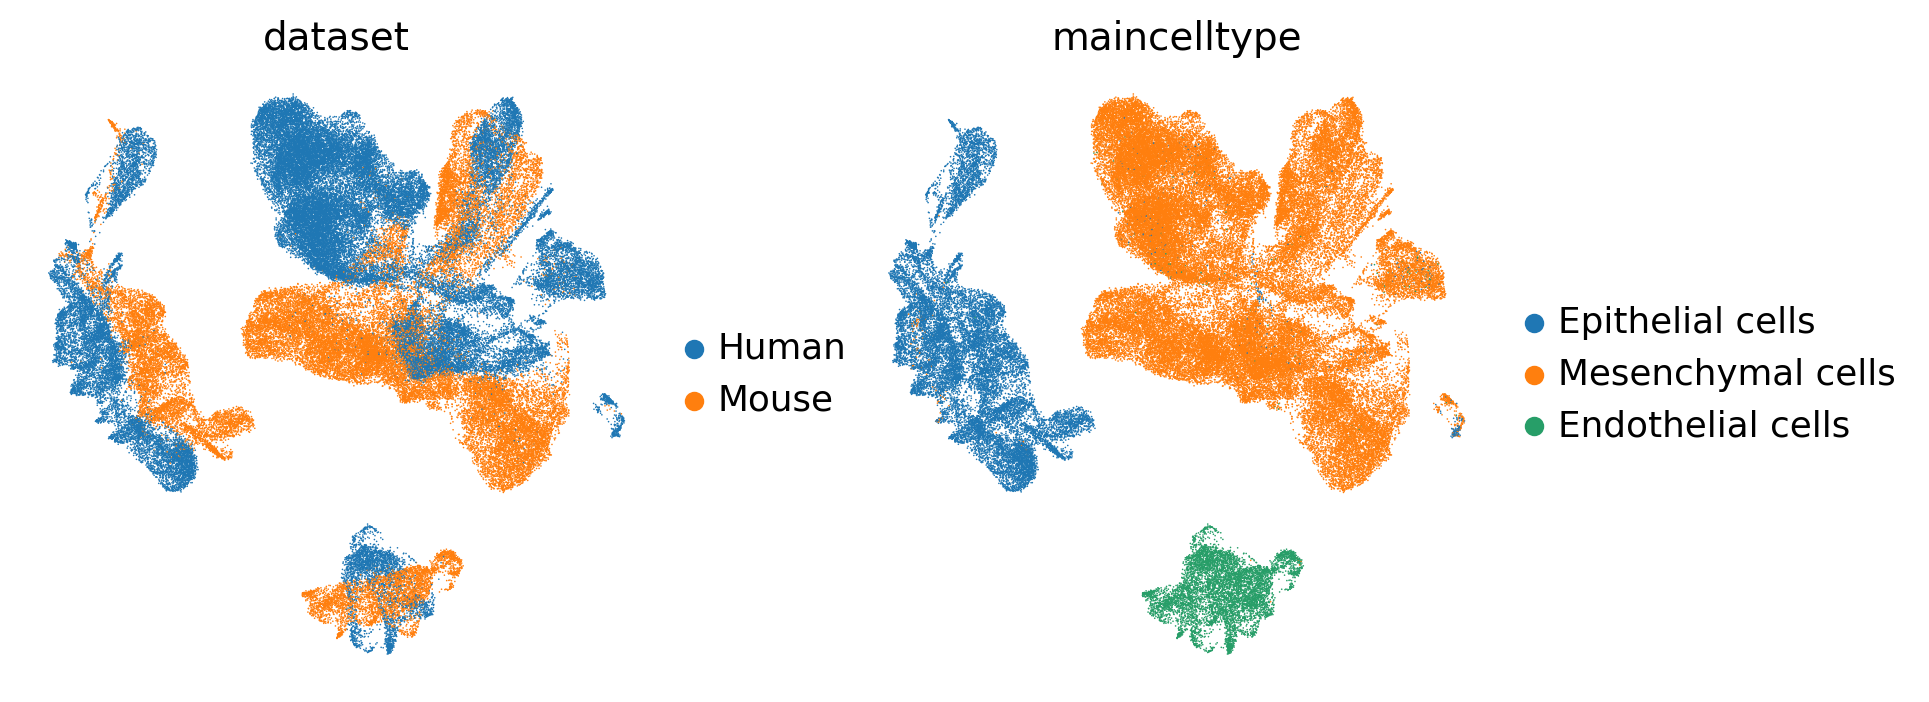

In [46]:
# 4. Visualization
np.random.seed(1)
o=np.random.choice(np.arange(adata.shape[0]), adata.shape[0], replace=False) 
sc.pl.embedding(adata[o],basis = 'X_umap_pca_harmony', color = ['dataset','maincelltype'], frameon=False)

### 2.2 Perform Harmony with CCA

In [61]:
del adata.obsm['X_cca']
del adata.obsm['X_pca']

In [62]:
# 1. Perform CCA
key = 'dataset'
adata = de.runCCA(adata, adata.obs[key]=='Human',adata.obs[key]=='Mouse', use_rep=None,features= None,n_components=40) 

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:744: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Receiv

In [63]:
# 2. Perform harmony integration
sce.pp.harmony_integrate(adata, key, basis = 'X_cca', adjusted_basis = 'X_cca_harmony')

2025-11-25 00:11:38,168 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-25 00:11:55,734 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-25 00:11:56,737 - harmonypy - INFO - Iteration 1 of 10
2025-11-25 00:13:22,739 - harmonypy - INFO - Iteration 2 of 10
2025-11-25 00:14:48,445 - harmonypy - INFO - Iteration 3 of 10
2025-11-25 00:16:14,037 - harmonypy - INFO - Iteration 4 of 10
2025-11-25 00:17:03,645 - harmonypy - INFO - Iteration 5 of 10
2025-11-25 00:17:42,331 - harmonypy - INFO - Iteration 6 of 10
2025-11-25 00:18:21,545 - harmonypy - INFO - Iteration 7 of 10
2025-11-25 00:18:57,036 - harmonypy - INFO - Iteration 8 of 10
2025-11-25 00:19:28,146 - harmonypy - INFO - Iteration 9 of 10
2025-11-25 00:19:58,932 - harmonypy - INFO - Iteration 10 of 10
2025-11-25 00:20:29,646 - harmonypy - INFO - Stopped before convergence


In [71]:
# 3. Perform UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_cca_harmony')
sc.tl.umap(adata)
adata.obsm['X_umap_cca_harmony'] = adata.obsm['X_umap']

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


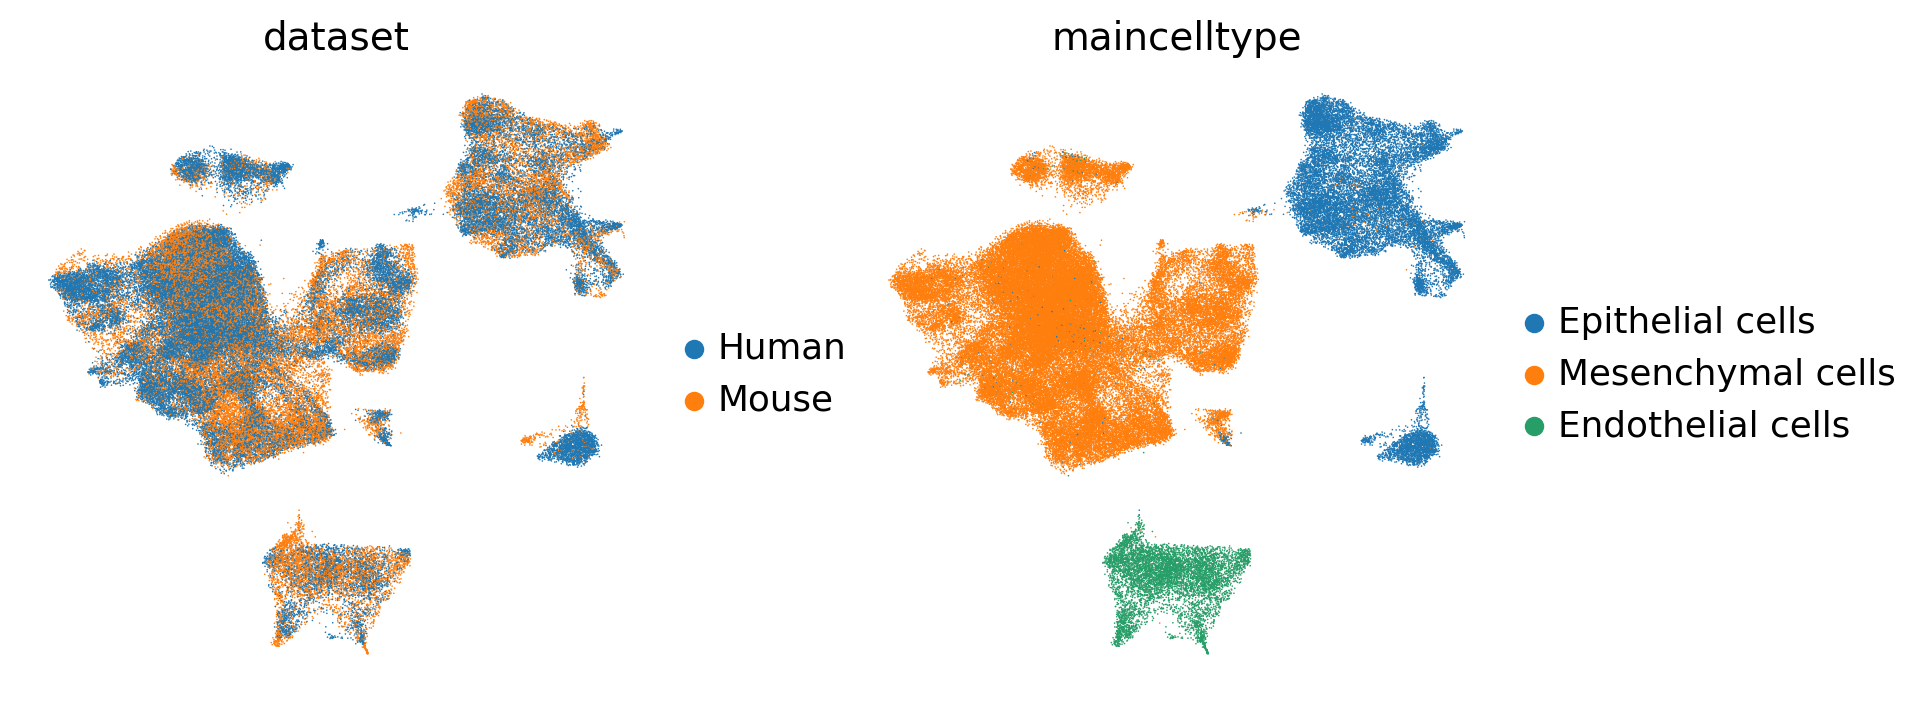

In [72]:
# 4. Visualization
np.random.seed(1)
o=np.random.choice(np.arange(adata.shape[0]), adata.shape[0], replace=False) 
sc.pl.embedding(adata[o],basis = 'X_umap_cca_harmony', color = ['dataset','maincelltype'], frameon=False)